In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
from json import load
import tifffile
from tqdm import tqdm
from skimage.draw import polygon
from matplotlib import rcParams
import glasbey

palette = {
    "green": "#558150",
    "beige": "#F1E2C3",
    "brown": "#A7785A",
    "pink": "#F0D6C2",
    "black": "#0E0E0E",
}

rcParams['font.family'] = 'sans-serif'
rcParams['figure.facecolor'] = "#FFFFFF00"
rcParams['axes.facecolor'] = "#FFFFFF00"
rcParams['legend.framealpha'] = 0.2
rcParams['axes.edgecolor'] = palette["black"]
rcParams['axes.labelcolor'] = palette["black"]
rcParams['xtick.color'] = palette["black"]
rcParams['ytick.color'] = palette["black"]
rcParams['text.color'] = palette["black"]
rcParams['axes.titlecolor'] = palette["black"]

s_palette = sns.cubehelix_palette(as_cmap=True)

In [4]:
from src.utils.tracklets import import_tracklets

roots = ["embryo007", "embryo008", "embryo014a", "embryo016", "embryo018"]
datapath = Path().cwd().parent / "data" / "interim" / "confocal"
plotpath = datapath / "plots"
plotpath.mkdir(exist_ok=True)

spots, tracklets, metadata, tracklets_joined = import_tracklets(datapath, roots)

In [5]:
print(spots[roots[0]].columns)

Index(['Unnamed: 0', 'ID', 'track_id', 'tracklet_id', 'distance_from_edge',
       'parent_id', 'daughter_id', 'roi', 'FRAME', 'POSITION_X', 'POSITION_Y',
       'POSITION_Z', 'ELLIPSE_MAJOR', 'ELLIPSE_MINOR', 'ELLIPSE_THETA',
       'ELLIPSE_Y0', 'ELLIPSE_X0', 'ELLIPSE_ASPECTRATIO', 'CIRCULARITY',
       'AREA', 'SHAPE_INDEX', 'MEDIAN_INTENSITY_CH1', 'time', 'um_from_edge',
       'um_x', 'um_y', 'ap_position', 'edge_position', 'track_n_tracklets',
       'cycle'],
      dtype='object')


In [6]:
fully_tracked = tracklets_joined[tracklets_joined["track_n_tracklets"] == 31].copy()
assigned_tracklets = tracklets_joined[(tracklets_joined["n_children"]==2) | (tracklets_joined["parent_tracklet"] != -1)].copy()

C:\Users\Harrison\AppData\Local\Temp\ipykernel_15820\3813633603.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ft_spot.loc[:, "area_um"] = ft_spot["AREA"] / metadata[root]["pixels_per_um"]**2
5000it [00:02, 1917.18it/s]


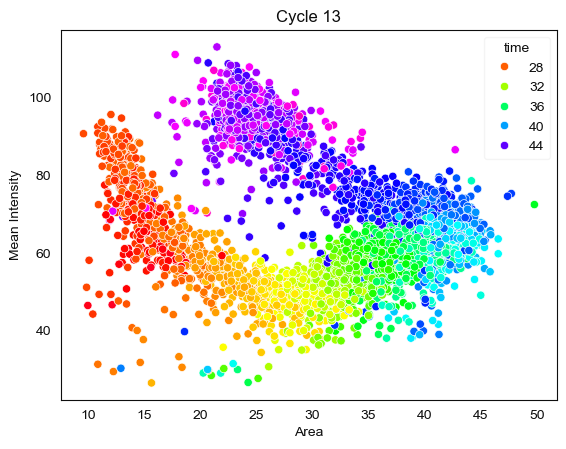

KeyError: 'intensity_mean'

In [10]:
from scipy.interpolate import CubicSpline

root = "embryo016"
spot = spots[root]
ft_spot = spot[spot["track_n_tracklets"] == 31]
ft_spot.loc[:, "area_um"] = ft_spot["AREA"] / metadata[root]["pixels_per_um"]**2

cycle = 13
sample = ft_spot[ft_spot["cycle"]==cycle].sample(5000)

rawfile = datapath / root / f"{root}_MaxIP_bgs.tif"
raw = tifffile.imread(rawfile)
shape = raw.shape

sample["intensity_mean"] = 0.0
sample["intensity_std"] = 0.0
sample["intensity_varrat"] = 0.0

for i, spot in tqdm(sample.iterrows()):
    x, y = spot["POSITION_X"], spot["POSITION_Y"]
    t = round(spot["FRAME"])
    new_track_id = spot["track_id"]
    
    roi = [float(pt.lstrip("[ ").rstrip("] ")) for pt in spot["roi"].split(",")]

    xs = [round(pt + x) for pt in roi[::2]]
    ys = [round(pt + y) for pt in roi[1::2]]

    rr, cc = polygon(ys, xs, shape[1:])
    intensity_vals = raw[tuple([t] + [rr, cc])]
    
    # take variance ratio of intensity vals 
    sample.loc[i, "intensity_mean"] = intensity_vals.mean()
    sample.loc[i, "intensity_std"] = intensity_vals.std()
    sample.loc[i, "intensity_stdrat"] = intensity_vals.std() / intensity_vals.mean()
    
sns.scatterplot(sample, x="area_um", y="intensity_mean", hue="time", palette="gist_rainbow")
plt.title(f"Cycle {cycle}")
plt.xlabel("Area")
plt.ylabel("Mean Intensity")
plt.savefig(plotpath / f"cycle_{cycle}_intensity_scatter.png")

plt.show()

next_intensity = sample["intensity_mean"] - sample["daughter_id"].map(ft_spot["intensity_mean"])
print(next_intensity)
# fig = plt.figure()
# ax1 = fig.add_subplot(111, projection='3d')
# 
# ax1.scatter(sample["AREA"], sample["intensity_mean"], sample["ELLIPSE_ASPECTRATIO"], c=sample["time"], cmap="gist_rainbow")
# ax1.set_xlabel("Area")
# ax1.set_ylabel("Mean Intensity")
# ax1.set_zlabel("Aspect Ratio")
# plt.title(f"Cycle {cycle}")
# plt.savefig(plotpath / f"cycle_{cycle}_3dscatter.png")
# plt.show()


In [11]:
root = "embryo016"
spot = spots[root]
ft_spot = spot[spot["track_n_tracklets"] == 31].copy()
ft_spot.loc[:, "area_um"] = ft_spot["AREA"] / metadata[root]["pixels_per_um"]**2

cycle = 13

rawfile = datapath / root / f"{root}_MaxIP_bgs.tif"
raw = tifffile.imread(rawfile)
shape = raw.shape

ft_spot["intensity_mean"] = 0.0
ft_spot["intensity_std"] = 0.0
ft_spot["intensity_varrat"] = 0.0

for i, spot in tqdm(ft_spot.iterrows()):
    x, y = spot["POSITION_X"], spot["POSITION_Y"]
    t = round(spot["FRAME"])
    new_track_id = spot["track_id"]
    
    roi = [float(pt.lstrip("[ ").rstrip("] ")) for pt in spot["roi"].split(",")]

    xs = [round(pt + x) for pt in roi[::2]]
    ys = [round(pt + y) for pt in roi[1::2]]

    rr, cc = polygon(ys, xs, shape[1:])
    intensity_vals = raw[tuple([t] + [rr, cc])]
    
    # take variance ratio of intensity vals 
    ft_spot.loc[i, "intensity_mean"] = intensity_vals.mean()
    ft_spot.loc[i, "intensity_std"] = intensity_vals.std()
    ft_spot.loc[i, "intensity_stdrat"] = intensity_vals.std() / intensity_vals.mean()


87958it [00:44, 1967.21it/s]


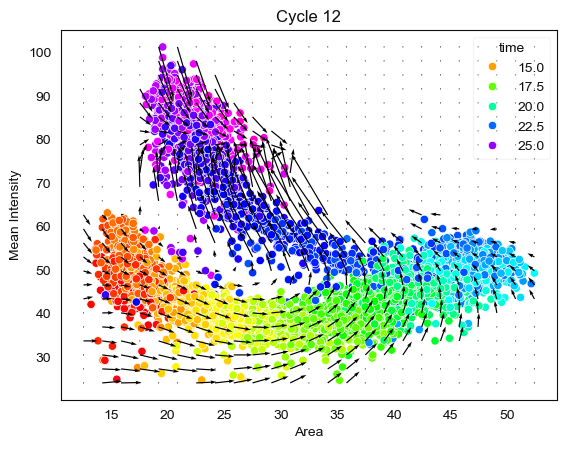

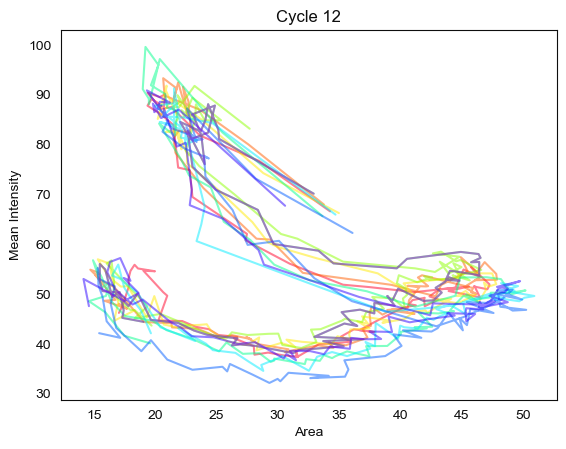

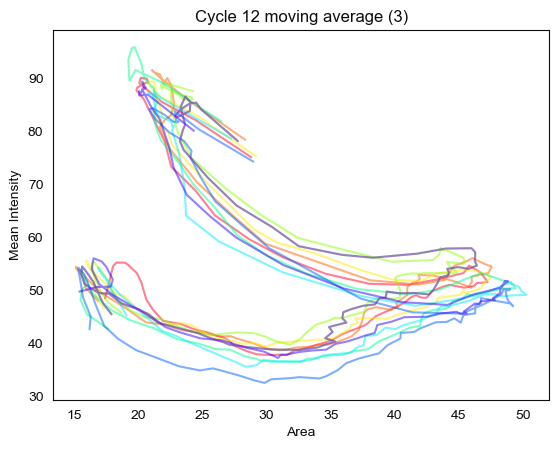

In [12]:
from scipy.spatial.distance import cdist

cycle = 12
spot_cycle = ft_spot[ft_spot["cycle"]==cycle].copy()

spot_cycle["intensity_next"] = spot_cycle["daughter_id"].map(spot_cycle.set_index("ID")["intensity_mean"]) - spot_cycle["intensity_mean"]
spot_cycle["area_next"] = spot_cycle["daughter_id"].map(spot_cycle.set_index("ID")["area_um"]) - spot_cycle["area_um"]

sample = spot_cycle.sample(5000)
sample = sample.dropna()

x_min, x_max = spot_cycle["area_um"].min(), spot_cycle["area_um"].max()
y_min, y_max = spot_cycle["intensity_mean"].min(), spot_cycle["intensity_mean"].max()
k = 25
xy, yx = np.meshgrid(np.linspace(x_min, x_max, k), np.linspace(y_min, y_max, k))
dis = cdist(sample[["area_um", "intensity_mean"]], np.c_[xy.ravel(), yx.ravel()])
weight = np.exp(-dis**2 / 8**2)
weightsum = weight.sum(axis=0)
weight = weight / weight.sum(axis=0)

# multiply each weight by the intensity_next
intensity_next = np.dot(sample["intensity_next"], weight)
area_next = np.dot(sample["area_next"], weight)

threshold = 2
intensity_next[dis.min(axis=0) > threshold] = 0
area_next[dis.min(axis=0) > threshold] = 0
# plt.hist(dis.min(axis=0), bins=25)
# plt.show()

fig, ax = plt.subplots()
sns.scatterplot(sample, x="area_um", y="intensity_mean", hue="time", palette="gist_rainbow", ax=ax)
plt.quiver(xy, yx, area_next, intensity_next)
plt.title(f"Cycle {cycle}")
plt.xlabel("Area")
plt.ylabel("Mean Intensity")
plt.savefig(plotpath / f"cycle_{cycle}_intensity_quiver.png")
plt.show()

def moving_average(a, k=3):
    return np.convolve(a, np.ones(k), "valid") / k

fig1, ax1 = plt.subplots()
fig2, ax2 = plt.subplots()
cmap = plt.get_cmap("gist_rainbow")
n=10
for i, t in enumerate(spot_cycle["tracklet_id"].sample(n)):
    if t == 0:
        continue
    area = spot_cycle[spot_cycle["tracklet_id"] == t]["area_um"]
    intensity = spot_cycle[spot_cycle["tracklet_id"] == t]["intensity_mean"]
    ax1.plot(area, intensity, color=cmap(i/n), alpha=0.5)
    
    area = moving_average(area, 3)
    intensity = moving_average(intensity, 3)
    
    ax2.plot(area, intensity, color=cmap(i/n), alpha=0.5)
ax1.set_title(f"Cycle {cycle}")
ax1.set_xlabel("Area")
ax1.set_ylabel("Mean Intensity")
ax2.set_title(f"Cycle {cycle} moving average (3)")
ax2.set_xlabel("Area")
ax2.set_ylabel("Mean Intensity")
fig1.savefig(plotpath / f"cycle_{cycle}_intensity_raw.png")
fig2.savefig(plotpath / f"cycle_{cycle}_intensity_movingavg.png")
plt.show()

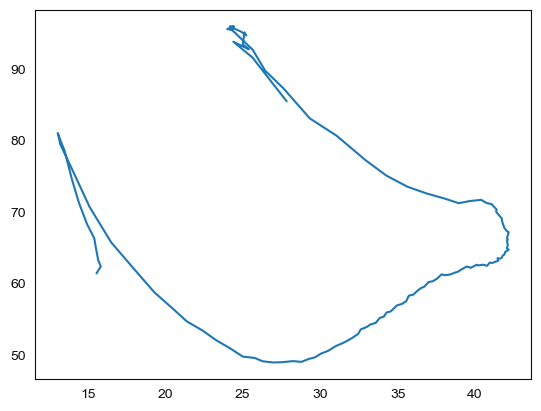

In [162]:
cycle=13
xs = ft_spot[ft_spot["cycle"]==cycle].groupby("time")[["area_um", "intensity_mean"]].median()
count = ft_spot[ft_spot["cycle"]==cycle].groupby("time").size()
min_xs = xs[count > 15]
plt.plot(min_xs["area_um"], min_xs["intensity_mean"])

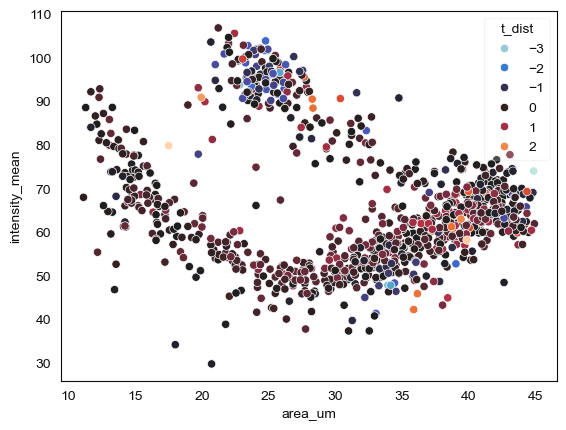

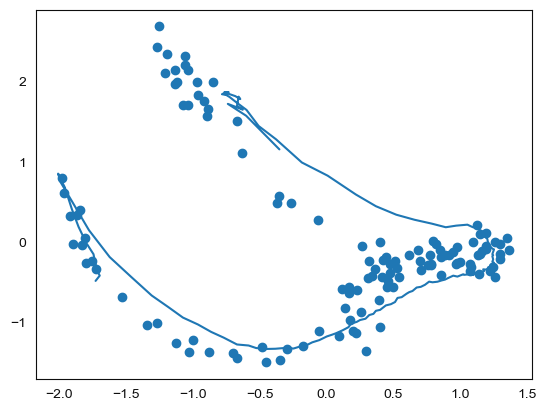

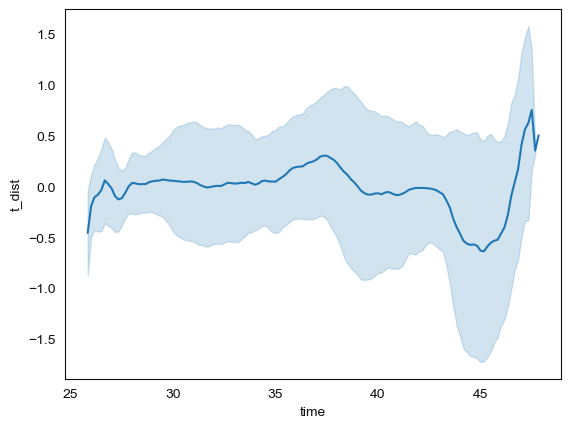

In [163]:
from dtw import dtw

def normalize(df):
    return (df - df.mean()) / df.std()

def get_times(alignment, time_series):
    times = {i: [] for i in alignment.index1s}
    counts = {i: 0 for i in alignment.index1s}
    for i, j in zip(alignment.index1s, alignment.index2s):
        times[i].append(time_series[j])
        counts[i] += 1
    return [np.mean(v) for v in times.values()], counts

template = normalize(min_xs)
ft_cycle = ft_spot[ft_spot["cycle"]==cycle].copy()
tracklet_ids = ft_cycle["tracklet_id"].unique()
queries = [normalize(ft_cycle[ft_cycle["tracklet_id"]==t].sort_values(by="time")[["area_um", "intensity_mean"]]) for t in tracklet_ids]
ft_cycle["dtw"] = 0.0

distances = []
for t, query in zip(tracklet_ids, queries):
    alignment = dtw(np.array(query), np.array(template))
    distances.append(alignment.normalizedDistance)
    times, counts = get_times(alignment, template.index)

    for spot_id, time, count in zip(query.index, times, counts):
        ft_cycle.loc[spot_id, "dtw"] = time
        ft_cycle.loc[spot_id, "dtw_count"] = count
        
ft_cycle["t_dist"] = ft_cycle["time"] - ft_cycle["dtw"]
    
    
sns.scatterplot(ft_cycle.sample(1000), x="area_um", y="intensity_mean", hue="t_dist", palette="icefire")
plt.show()
    
plt.scatter(query["area_um"], query["intensity_mean"])
plt.plot(template["area_um"], template["intensity_mean"])
plt.show()

sns.lineplot(ft_cycle, x="time", y="t_dist", estimator="mean", errorbar="sd")
plt.show()

In [160]:
shape = (len(ft_cycle["FRAME"].unique()), metadata[root]["h"], metadata[root]["w"])
vis_tif = np.ones(shape) * -10

ft_cycle["dtw_dis"] = ft_cycle["dtw"] - ft_cycle["time"].map(ft_cycle.groupby("time")["dtw"].mean())

for i, spot in tqdm(ft_cycle.iterrows()):
    x, y = spot["POSITION_X"], spot["POSITION_Y"]
    t = round(spot["FRAME"]) - round(ft_cycle["FRAME"].min())
    new_track_id = spot["track_id"]
    
    roi = [float(pt.lstrip("[ ").rstrip("] ")) for pt in spot["roi"].split(",")]

    xs = [round(pt + x) for pt in roi[::2]]
    ys = [round(pt + y) for pt in roi[1::2]]

    rr, cc = polygon(ys, xs, shape[1:])
    vis_tif[t, rr, cc] = spot["dtw_dis"]
    
tifffile.imwrite(plotpath / f"cycle_{cycle}_dtw.tif", vis_tif.astype(np.float16))

6086it [00:01, 3304.02it/s]


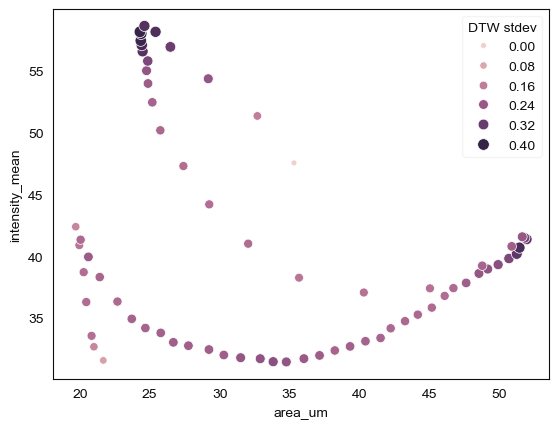

<Axes: xlabel='dtw_dis', ylabel='Count'>

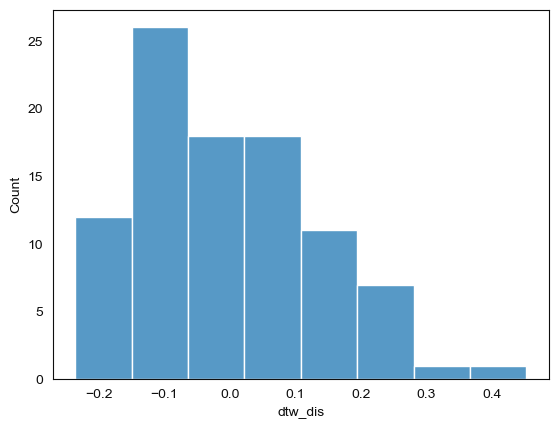

In [161]:
vals = ft_cycle.groupby("time").agg({"dtw_dis": "std", "area_um": "mean", "intensity_mean": "mean"})
sns.scatterplot(vals, x="area_um", y="intensity_mean", hue="dtw_dis", size="dtw_dis")
plt.legend(title="DTW stdev")
plt.savefig(plotpath / f"cycle_{cycle}_dtw_std_scatter.png", dpi=300)
plt.show()

fig, ax = plt.subplots()

sns.histplot(x=ft_cycle.groupby("tracklet_id")["dtw_dis"].mean(), ax=ax)

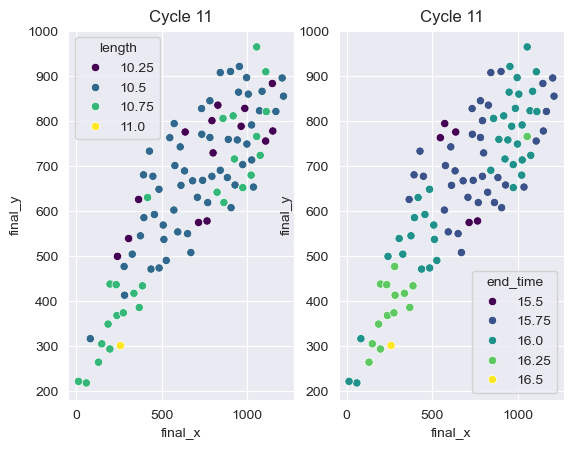

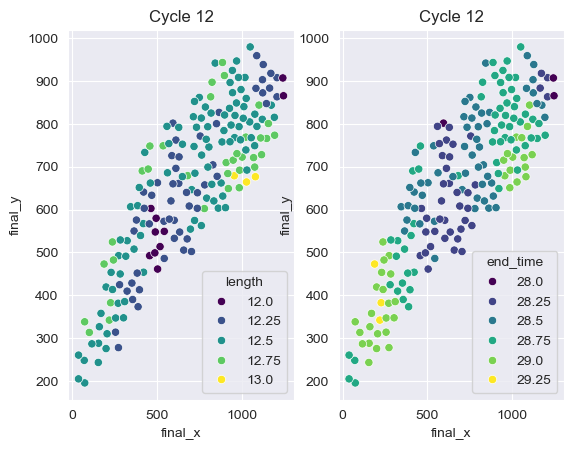

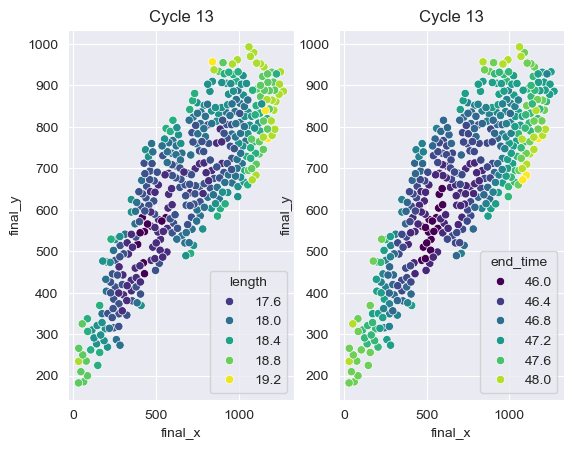

In [34]:
for nc in range(11, 14):

    nc_df = fully_tracked[fully_tracked["cycle"] == nc]
    no_out = nc_df[(np.abs(nc_df["length"] - nc_df["length"].mean()) < 4*nc_df["length"].std())]
    
    embryo = roots[1]
    no_out = no_out[no_out["embryo"] == embryo]
    fig, axes = plt.subplots(1, 2)
    for ax, hue in zip(axes, ["length", "end_time"]):
        sns.scatterplot(
            data=no_out,
            x="final_x",
            y="final_y",
            hue=hue,
            palette="viridis",
            ax=ax
        )
        ax.set_title(f"Cycle {nc}")
    
    plt.title(f"Cycle {nc}")
    plt.savefig(plotpath / f"cycle_{nc}_end_spacescatter.png")
    plt.show()